# libairies

In [148]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from datetime import datetime
import arff
#Ignorer les warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Attribute information: 
1. seismic: result of shift seismic hazard assessment in the mine working obtained by the seismic 
method (a - lack of hazard, b - low hazard, c - high hazard, d - danger state); 
2. seismoacoustic: result of shift seismic hazard assessment in the mine working obtained by the 
seismoacoustic method; 
3. shift: information about type of a shift (W - coal-getting, N -preparation shift); 
4. genergy: seismic energy recorded within previous shift by the most active geophone (GMax) out of 
geophones monitoring the longwall; 
5. gpuls: a number of pulses recorded within previous shift by GMax; 
6. gdenergy: a deviation of energy recorded within previous shift by GMax from average energy recorded 
during eight previous shifts; 
7. gdpuls: a deviation of a number of pulses recorded within previous shift by GMax from average number 
of pulses recorded during eight previous shifts; 
8. ghazard: result of shift seismic hazard assessment in the mine working obtained by the 
seismoacoustic method based on registration coming form GMax only; 
9. nbumps: the number of seismic bumps recorded within previous shift; 
10. nbumps2: the number of seismic bumps (in energy range [10^2,10^3)) registered within previous shift; 
11. nbumps3: the number of seismic bumps (in energy range [10^3,10^4)) registered within previous shift; 
12. nbumps4: the number of seismic bumps (in energy range [10^4,10^5)) registered within previous shift; 
13. nbumps5: the number of seismic bumps (in energy range [10^5,10^6)) registered within the last shift; 
14. nbumps6: the number of seismic bumps (in energy range [10^6,10^7)) registered within previous shift; 
15. nbumps7: the number of seismic bumps (in energy range [10^7,10^8)) registered within previous shift; 
16. nbumps89: the number of seismic bumps (in energy range [10^8,10^10)) registered within previous shift; 
17. energy: total energy of seismic bumps registered within previous shift; 
18. maxenergy: the maximum energy of the seismic bumps registered within previous shift; 
19. class: the decision attribute - '1' means that high energy seismic bump occurred in the next shift 
('hazardous state'), '0' means that no high energy seismic bumps occurred in the next shift 
('non-hazardous state').

# Bonus Scrapping

In [1]:
from selenium import webdriver
driver = webdriver.Firefox(executable_path=r'geckodriver.exe')#uniquement sur windows

### 1) Obtention du lien de téléchargement du fichier

In [2]:
original_link='https://archive.ics.uci.edu/ml/datasets/seismic-bumps'
driver.get(original_link)
links1 = driver.find_elements_by_xpath('/html/body/table[2]/tbody/tr/td/table[1]/tbody/tr/td[1]/p[1]/span[2]/a[1]')
for link in links1:
    link.click()
links2 = driver.find_elements_by_xpath('/html/body/table/tbody/tr[4]/td[2]/a')
path_datas=""
for link in links2:
    path_datas=link.get_attribute("href")
print(path_datas)

https://archive.ics.uci.edu/ml/machine-learning-databases/00266/seismic-bumps.arff


# import du dataset

In [149]:
inputFile = 'seismic_bumps.arff'
arffData = arff.load(open(inputFile))
df = pd.DataFrame(arffData['data'])
df.columns = ['seismic','seismoacoustic','shift','genergy','gpuls','gdenergy','gdpuls','ghazard','nbumps',
                         'nbumps2','nbumps3','nbumps4','nbumps5','nbumps6','nbumps7','nbumps89','energy','maxenergy','class']

In [150]:
#dimension
print(df.shape)

(2584, 19)


In [151]:
#type des variables
print(df.dtypes)

seismic            object
seismoacoustic     object
shift              object
genergy           float64
gpuls             float64
gdenergy          float64
gdpuls            float64
ghazard            object
nbumps            float64
nbumps2           float64
nbumps3           float64
nbumps4           float64
nbumps5           float64
nbumps6           float64
nbumps7           float64
nbumps89          float64
energy            float64
maxenergy         float64
class              object
dtype: object


In [152]:
#Statitiques sur les toutes les varibles du dataset
print(df.describe())

            genergy        gpuls     gdenergy       gdpuls       nbumps      nbumps2      nbumps3  \
count  2.584000e+03  2584.000000  2584.000000  2584.000000  2584.000000  2584.000000  2584.000000   
mean   9.024252e+04   538.579334    12.375774     4.508901     0.859520     0.393576     0.392802   
std    2.292005e+05   562.652536    80.319051    63.166556     1.364616     0.783772     0.769710   
min    1.000000e+02     2.000000   -96.000000   -96.000000     0.000000     0.000000     0.000000   
25%    1.166000e+04   190.000000   -37.000000   -36.000000     0.000000     0.000000     0.000000   
50%    2.548500e+04   379.000000    -6.000000    -6.000000     0.000000     0.000000     0.000000   
75%    5.283250e+04   669.000000    38.000000    30.250000     1.000000     1.000000     1.000000   
max    2.595650e+06  4518.000000  1245.000000   838.000000     9.000000     8.000000     7.000000   

           nbumps4      nbumps5  nbumps6  nbumps7  nbumps89         energy      maxenergy 

In [153]:
# pondération de la varible target
print(df.groupby('class').size())

class
0    2414
1     170
dtype: int64


In [154]:
# les valeures manquantes 
print(df.isnull().sum())

seismic           0
seismoacoustic    0
shift             0
genergy           0
gpuls             0
gdenergy          0
gdpuls            0
ghazard           0
nbumps            0
nbumps2           0
nbumps3           0
nbumps4           0
nbumps5           0
nbumps6           0
nbumps7           0
nbumps89          0
energy            0
maxenergy         0
class             0
dtype: int64


# Data vizualisation

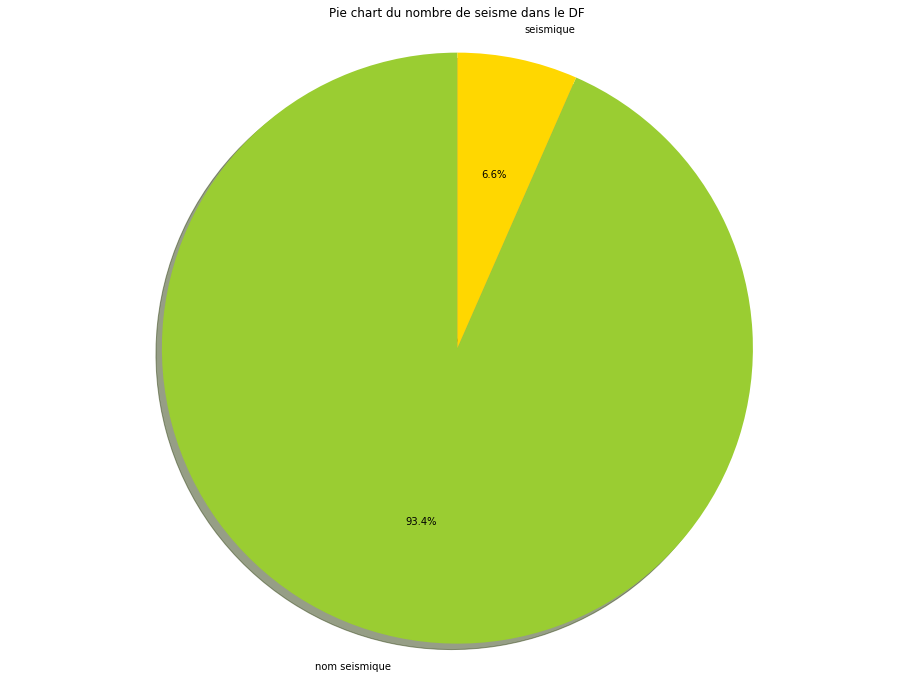

In [155]:

import matplotlib.pyplot as plt

labels = 'nom seismique', 'seismique'
sizes = [df['class'].value_counts()[0], df['class'].value_counts()[1]]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Pie chart du nombre de seisme dans le DF')
plt.savefig('PieChart01.png')
plt.show()


In [156]:
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

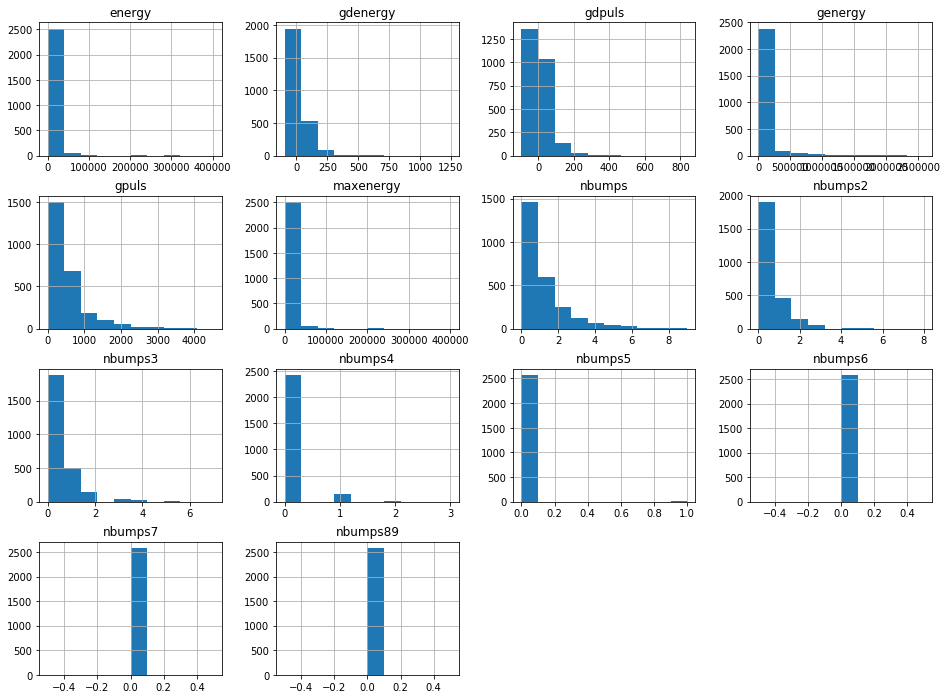

In [157]:
# Histogramme de chaque variable
df.hist()
pyplot.show()

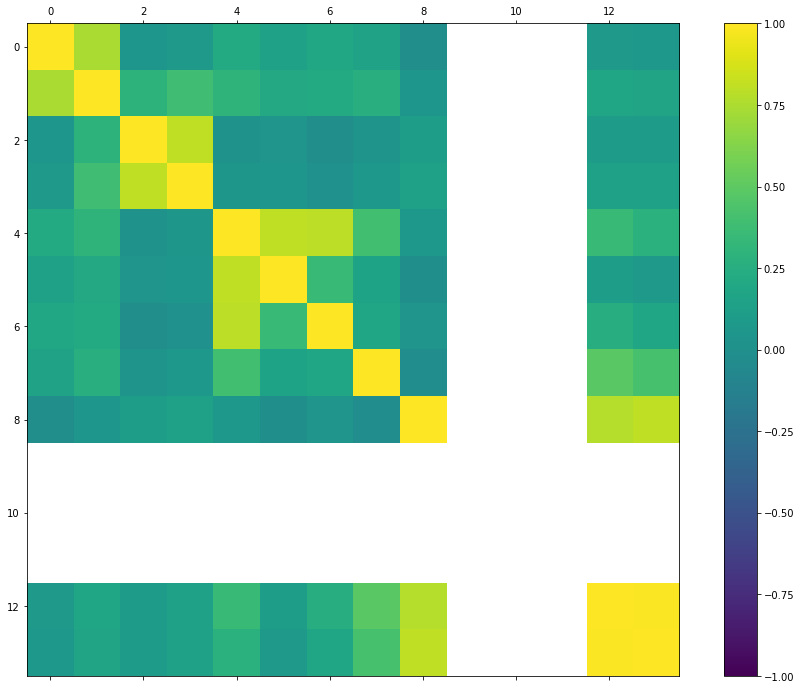

In [158]:
# Matrice de corrélation pour les variables les plus importantes 
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

C:\Users\S080934\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
C:\Users\S080934\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


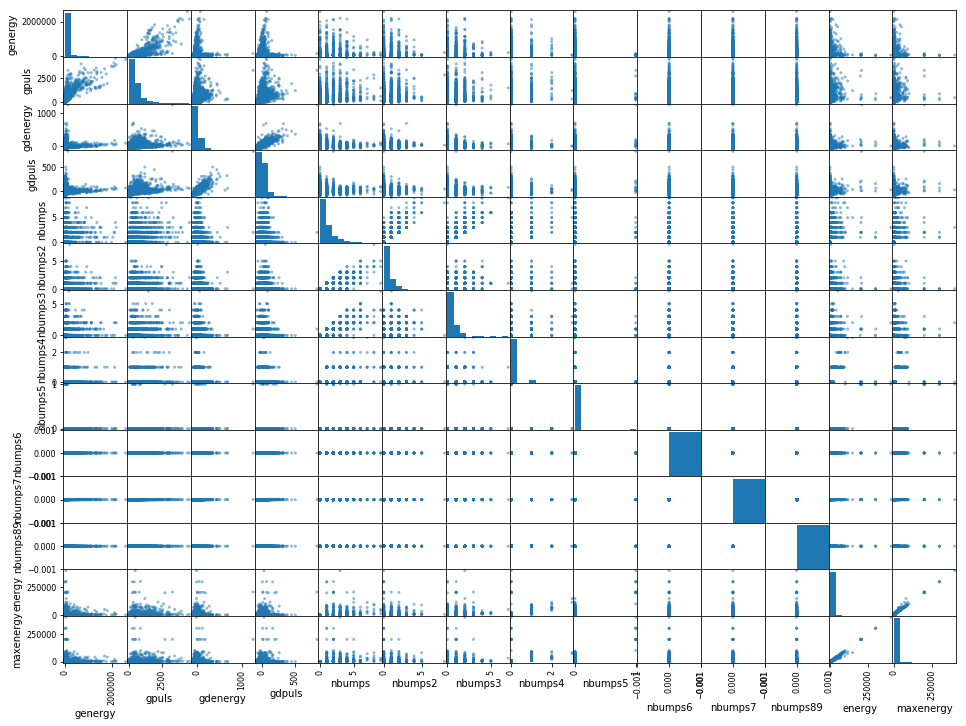

In [159]:
# Matrice de nuage de points
scatter_matrix(df)
pyplot.show()

# Preparation des données

In [160]:
# Conversion des variables string en catégorielle
df["seismic"] = df["seismic"].astype('category')
df["seismoacoustic"] = df["seismoacoustic"].astype('category')
df["shift"] = df["shift"].astype('category')
df["ghazard"] = df["ghazard"].astype('category')

# Application du hot encoding pour les variables non numériques
df_dummies = get_dummies(df)
df_dummies['class'] = df_dummies['class_1']
df_dummies.pop('class_0')
df_dummies.pop('class_1')
print(df_dummies.dtypes)

genergy             float64
gpuls               float64
gdenergy            float64
gdpuls              float64
nbumps              float64
nbumps2             float64
nbumps3             float64
nbumps4             float64
nbumps5             float64
nbumps6             float64
nbumps7             float64
nbumps89            float64
energy              float64
maxenergy           float64
seismic_a             uint8
seismic_b             uint8
seismoacoustic_a      uint8
seismoacoustic_b      uint8
seismoacoustic_c      uint8
shift_N               uint8
shift_W               uint8
ghazard_a             uint8
ghazard_b             uint8
ghazard_c             uint8
class                 uint8
dtype: object


In [161]:
#toutes les variables sont numériques
print(df_dummies.head())

   genergy  gpuls  gdenergy  gdpuls  nbumps  nbumps2  nbumps3  nbumps4  nbumps5  nbumps6  ...    \
0  15180.0   48.0     -72.0   -72.0     0.0      0.0      0.0      0.0      0.0      0.0  ...     
1  14720.0   33.0     -70.0   -79.0     1.0      0.0      1.0      0.0      0.0      0.0  ...     
2   8050.0   30.0     -81.0   -78.0     0.0      0.0      0.0      0.0      0.0      0.0  ...     
3  28820.0  171.0     -23.0    40.0     1.0      0.0      1.0      0.0      0.0      0.0  ...     
4  12640.0   57.0     -63.0   -52.0     0.0      0.0      0.0      0.0      0.0      0.0  ...     

   seismic_b  seismoacoustic_a  seismoacoustic_b  seismoacoustic_c  shift_N  shift_W  ghazard_a  \
0          0                 1                 0                 0        1        0          1   
1          0                 1                 0                 0        1        0          1   
2          0                 1                 0                 0        1        0          1   
3        

In [162]:
totAttr = len(df_dummies.columns)-1
array = df_dummies.values
X_entire = array[:,0:totAttr]
Y_entire = df['class'].values
validation_size = 0.30
X_train, X_validation, Y_train, Y_validation = train_test_split(X_entire, Y_entire, test_size=validation_size, random_state=seedNum)
print("X_entire.shape: {} Y_entire.shape: {}".format(X_entire.shape, Y_entire.shape))
print("X_train.shape: {} Y_train.shape: {}".format(X_train.shape, Y_train.shape))
print("X_validation.shape: {} Y_validation.shape: {}".format(X_validation.shape, Y_validation.shape))
print ('Total time for data handling and visualization:',(datetime.now() - startTimeScript))

X_entire.shape: (2584, 24) Y_entire.shape: (2584,)
X_train.shape: (1808, 24) Y_train.shape: (1808,)
X_validation.shape: (776, 24) Y_validation.shape: (776,)
Total time for data handling and visualization: 3:32:46.399145


# Model et Algorithme

In [163]:
num_folds = 10
scoring = 'accuracy'

In [164]:

# Set up Algorithms Spot-Checking Array
models = []
models.append(('SVM', SVC(random_state=seedNum)))
results = []
names = []
metrics = []

In [165]:
# Generate model in turn
for name, model in models:
    startTimeModule = datetime.now()
    kfold = KFold(n_splits=num_folds, random_state=seedNum)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    metrics.append(cv_results.mean())
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print ('Model training time:',(datetime.now() - startTimeModule))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

SVM: 0.933643 (0.017604)
Model training time: 0:00:03.127813
Average metrics (accuracy) from all models: 0.9336433394720688


# Tuning de l'Algorithme

In [166]:
results = []
names = []

In [167]:
# Tuning algorithm #2 - Support Vector Machine
startTimeModule = datetime.now()
paramGrid2 = dict(C=np.array([0.25,0.5,0.75,1.0,2.0]))
model2 = SVC(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('SVM')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))

Best: 0.933628 using {'C': 0.25}
0.933628 (0.017606) with: {'C': 0.25}
0.933628 (0.017606) with: {'C': 0.5}
0.933628 (0.017606) with: {'C': 0.75}
0.933628 (0.017606) with: {'C': 1.0}
0.933628 (0.017606) with: {'C': 2.0}
Model training time: 0:00:30.538460


# Validation sur le dataset

In [168]:
model = SVC(random_state=seedNum)
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9355670103092784
[[726   0]
 [ 50   0]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97       726
          1       0.00      0.00      0.00        50

avg / total       0.88      0.94      0.90       776



C:\Users\S080934\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
